In [12]:
import torch
from torch import Tensor, nn
from math import ceil
from torch.autograd import Function

from torch.autograd.function import Function
import triton
import triton.language as tl

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [13]:

def validate_contiguous(x: Tensor) -> Tensor:
    return x if x.is_contiguous() else x.contiguous()


def validate_tensor_device(x: Tensor):
    if not x.is_cuda:
        message = "Tensor must be on CUDA or TRITON_INTERPRET must be set to '1'"
        assert os.environ.get("TRITON_INTERPRET", False) == "1", message


def is_cuda_available() -> bool:
    return torch.cuda.is_available()


def get_device() -> torch.device:
    device = "cuda" if torch.cuda.is_available() else "cpu"
    return torch.device(device)



@triton.jit
def _softmax_triton_fwd(
    x_pointer, y_pointer, x_stride, y_stride, n_rows, n_cols, block_size: tl.constexpr
):
    # get the program id: each program of the grid handles one (or more) rows of the tensor
    pid = tl.program_id(axis=0)

    # strided execution: can run the program in a strided way (e.g. for row 0, 8, 16, ...)
    row_step = tl.num_programs(axis=0)  # n. of programs running on given axis

    col_offset = tl.arange(0, block_size)
    # Create a mask to guard memory operations against out-of-bounds accesses.
    mask = col_offset < n_cols

    # loop through the rows executed by program with this pid
    for row_idx in tl.range(pid, n_rows, row_step):
        x_row_pointer = x_pointer + row_idx * x_stride
        x_col_pointer = x_row_pointer + col_offset

        # compute the softmax (with shift for numerical stab.)
        row = tl.load(x_col_pointer, mask, other=-float("inf"))

        row_minus_max = row - tl.max(row, axis=0)
        num = tl.exp(row_minus_max)
        den = tl.sum(num, axis=0)
        y = num / den

        y_row_pointer = y_pointer + row_idx * y_stride
        y_col_pointer = y_row_pointer + col_offset
        tl.store(y_col_pointer, y, mask)


def _softmax_fwd(x: Tensor, block_size: int = 1024) -> Tensor:
    validate_tensor_device(x)

    n_rows, n_cols = x.shape
    y = torch.empty_like(x)
    grid = (n_rows,)
    block_size = triton.next_power_of_2(n_cols)  # Used to tile the row

    _softmax_triton_fwd[grid](
        x, y, x.stride(0), y.stride(0), n_rows, n_cols, block_size
    )
    return y


@triton.jit
def load_tensor_row(x_ptr, row_idx, x_stride, col_ptr_offset, mask, other):
    # row pointer
    row_ptr = x_ptr + row_idx * x_stride

    # col pointer
    col_ptr = row_ptr + col_ptr_offset

    # load all tensors
    return tl.load(col_ptr, mask, other=other)


@triton.jit
def _softmax_triton_bwd(
    s_ptr,
    grad_output_ptr,
    grad_input_ptr,
    s_stride,
    grad_output_stride,
    grad_input_stride,
    nrows,
    ncols,
    block_size: tl.constexpr,
):

    pid = tl.program_id(axis=0)
    row_step = tl.num_programs(axis=0)
    col_ptr_offset = tl.arange(0, block_size)
    mask = col_ptr_offset < ncols

    for row_idx in tl.range(pid, nrows, row_step):
        ### load s
        s = tl.load(s_ptr + row_idx * s_stride + col_ptr_offset, mask)

        ### load grad_output
        grad_output = tl.load(
            grad_output_ptr + row_idx * grad_output_stride + col_ptr_offset,
            mask,
        )

        # perform coputations
        # grad_input = s * grad_output
        alpha = tl.sum(s * grad_output, axis=0)
        grad_input = s * (grad_output - alpha)

        # store the results
        tl.store(
            grad_input_ptr + row_idx * grad_input_stride + col_ptr_offset,
            grad_input,
            mask,
        )


def _softmax_bwd(s: Tensor, grad_output: Tensor, block_size: int = 1024) -> Tensor:
    for x in (s, grad_output):
        validate_tensor_device(x)

    nrows, ncols = s.shape
    grad_input = torch.empty_like(grad_output).to(s.device)
    grid = (nrows,)

    block_size = triton.next_power_of_2(ncols)

    _softmax_triton_bwd[grid](
        s,
        grad_output,
        grad_input,
        s.stride(0),
        grad_output.stride(0),
        grad_input.stride(0),
        nrows,
        ncols,
        block_size,
    )

    return grad_input


class SoftmaxFunction(Function):
    def forward(ctx, x):
        s = _softmax_fwd(x)
        ctx.save_for_backward(s)
        return s

    def backward(ctx, grad_output):
        (s,) = ctx.saved_tensors

        # exp = torch.exp(x)
        # den = exp.sum(dim=1)
        # derivative = (exp * (den - exp)) / den ** 2

        # y = torch.softmax(x, dim=1)
        # alpha = (s * grad_output).sum(dim=1, keepdim=True)
        # grad_input = s * (grad_output - alpha)

        grad_input = _softmax_bwd(s, grad_output)

        # derivative = _softmax_bwd(x)
        return grad_input


class Softmax(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        if x.ndim == 1:
            return SoftmaxFunction.apply(x[None, :]).squeeze()
        if x.ndim > 2:
            x = validate_contiguous(x)
            return SoftmaxFunction.apply(x.view(-1, x.shape[-1])).view(x.shape)
        return SoftmaxFunction.apply(x)


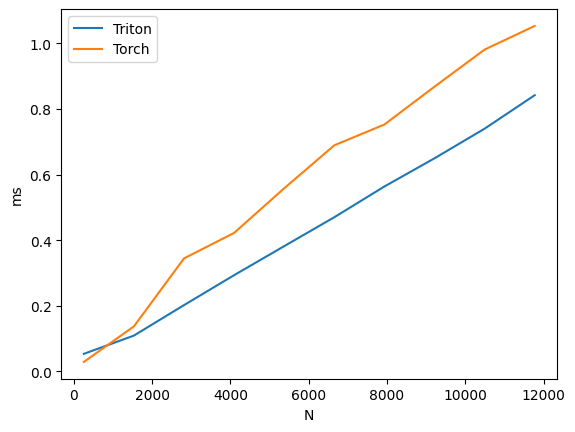

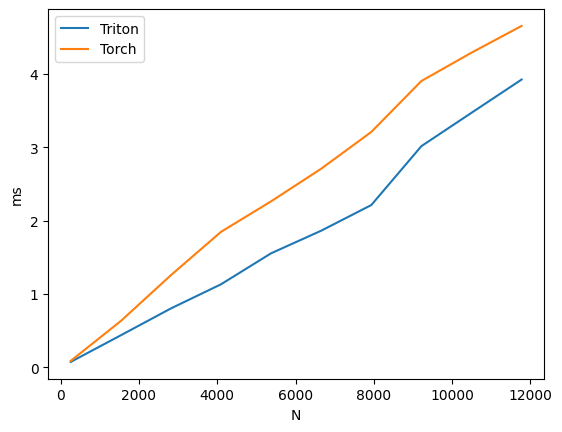

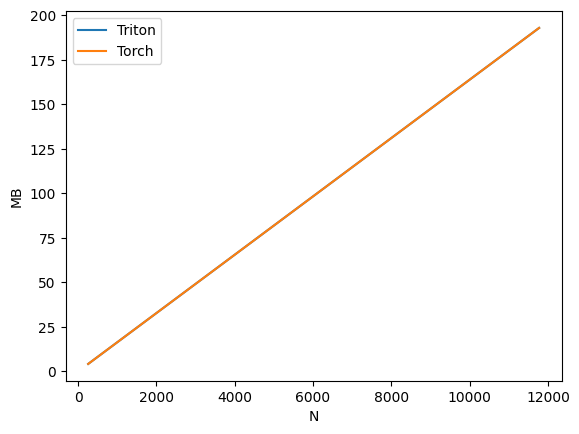

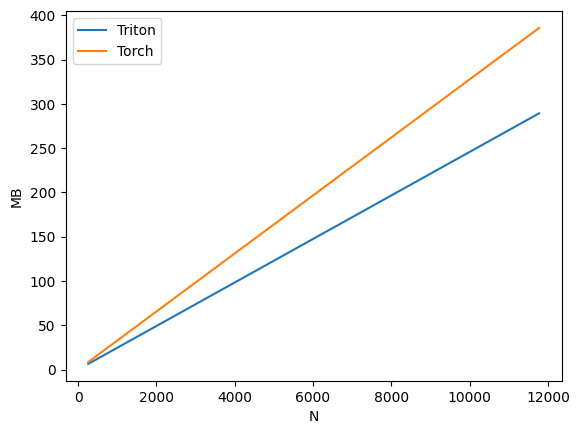

In [40]:


# def fwd(x, provider):
#     if provider == "torch":
#         return torch.nn.functional.softmax(x, dim=-1)#(x, axis=-1)
#     elif provider == 'triton':
#         return _fwd(x)
#     else:
#         raise ValueError

# def bwd(x, provider):
#     x.requires_grad = True
#     out = fwd(x, provider)

#     loss = out.sum()
#     loss.backward()

def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak


base_benchmark_kwargs = {
        "x_names":['N'],  # argument names to use as an x-axis for the plot
        "x_vals":[128 * i for i in range(2, 100, 10)],  # different possible values for `x_name`
        "line_arg":'provider',  # argument name whose value corresponds to a different line in the plot
        "line_vals":['triton', 'torch'],  # possible values for `line_arg``
        "line_names":["Triton", "Torch"],  # label name for the lines
        # "styles":[('blue', '-'), ('green', '-')],  # line styles
        "ylabel":"GB/s",  # label name for the y-axis
        "plot_name":"softmax",  # name for the plot. Used also as a file name for saving the plot.
        "args":{'M': 4096} # values for function arguments not in `x_names` and `y_name`
}

from copy import deepcopy
configs = []
for bench_kind in ['timing', 'memory']:
    for mode in ['fwd', 'bwd']:
        _kwargs = deepcopy(base_benchmark_kwargs)
        _kwargs['args'].update({"mode" : mode})
        _kwargs['args'].update({"bench_kind" : bench_kind})
        _kwargs['ylabel'] = 'ms' if bench_kind == 'timing' else 'MB'
        _kwargs['plot_name'] += f' - {bench_kind} - {mode}'
        configs.append(triton.testing.Benchmark(**_kwargs))


_fwd = Softmax()


def fwd(x, provider):
    if provider == "torch":
        return torch.nn.functional.softmax(x, dim=-1)#(x, axis=-1)
    elif provider == 'triton':
        return _fwd(x)
    else:
        raise ValueError

def bwd(x, provider):
    x.requires_grad = True
    out = fwd(x, provider)
    loss = out.sum()
    loss.backward()

MAP_FWD_BKW = {
    "fwd" : fwd,
    "bwd" : bwd,
}

def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak

def benchmark_kernel():

    # for c in configs:
    #     print(c.__dict__)

    @triton.testing.perf_report(configs)
    def benchmark(M, N, provider, mode, bench_kind):
        x = torch.randn(M, N, device=DEVICE, dtype=torch.bfloat16)
        stream = getattr(torch, DEVICE.type).Stream()
        getattr(torch, DEVICE.type).set_stream(stream)
        if bench_kind == "timing":
            ms = triton.testing.do_bench(lambda: MAP_FWD_BKW[mode](x, provider))
            # gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
            return ms #gbps(ms)
        elif bench_kind == "memory":
            mem_mb = measure_memory(MAP_FWD_BKW[mode], x, provider)
            return mem_mb
        raise ValueError(f"bench_kind must be either 'timing' or 'memory', got {bench_kind}")

    result_dfs = benchmark.run(show_plots=False, print_data=False, return_df=True)
    for df, config in zip(result_dfs, configs):
        df.plot(x='N', ylabel = config.ylabel, title=config.plot_name, legend=True)

    return result_dfs

result_dfs = benchmark_kernel()

In [33]:
df

,N,Triton,Torch
0,256.0,10.499072,12.596224
1,1536.0,41.956352,54.539264
2,2816.0,73.413632,96.482304
3,4096.0,104.870912,138.425344
4,5376.0,136.328192,180.368384
5,6656.0,167.785472,222.311424
6,7936.0,199.242752,264.254464
7,9216.0,230.700032,306.197504
8,10496.0,262.157312,348.140544
9,11776.0,293.614592,390.083584


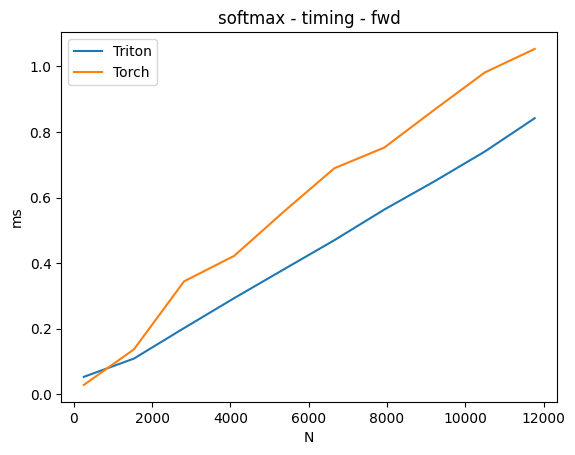

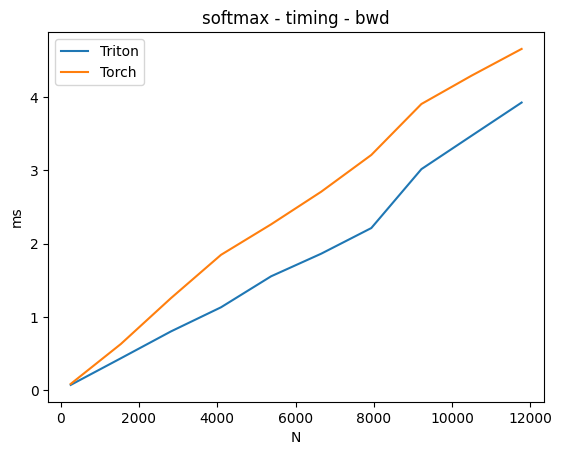

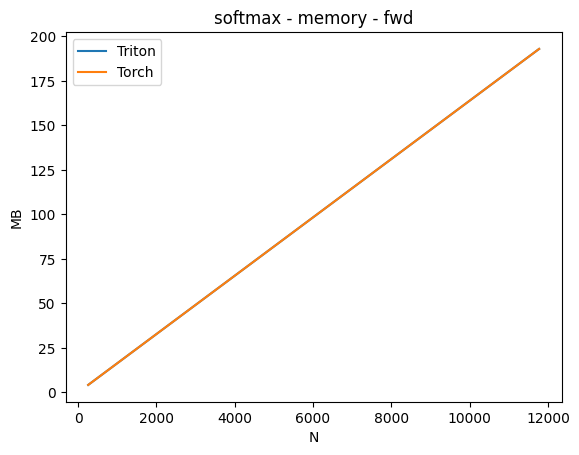

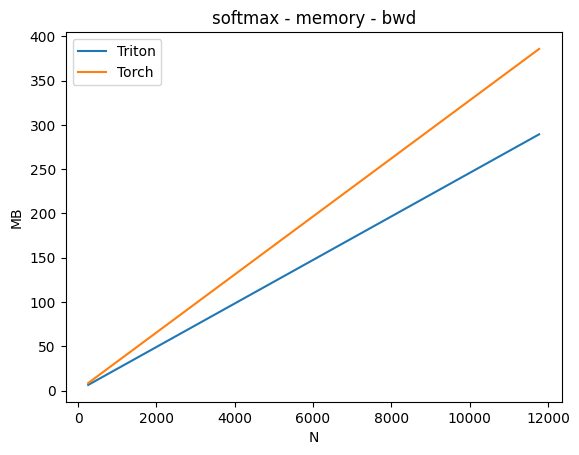

In [41]:
for df, config in zip(result_dfs, configs):
    # config.
    df.plot(x='N', ylabel = config.ylabel, title=config.plot_name, legend=True)

In [ ]:
from torch import nn, Tensor
import torch
from torch.autograd.function import Function
import triton
import triton.language as tl
from math import ceil, pi

import math

torch_ref_module = nn.GELU


# @triton.jit
# def _gelu_fwd_triton(
#     x_ptr, tanh_ptr, phi_ptr, act_ptr, num_elements, block_size: tl.constexpr
# ):

#     pid = tl.program_id(axis=0)
#     ptr_offset = pid * block_size + tl.arange(0, block_size)

#     mask = ptr_offset < num_elements

#     x = tl.load(x_ptr + ptr_offset, mask)

#     angle = tl.sqrt(2 / math.pi) * (x + 0.044715 * x * x * x)
#     tanh = (tl.exp(2 * angle) - 1) / (tl.exp(2 * angle) + 1)
#     phi = 0.5 * (1 + tanh)
#     chunk_act = x * phi

#     tl.store(tanh_ptr + ptr_offset, tanh, mask)
#     tl.store(phi_ptr + ptr_offset, phi, mask)
#     tl.store(act_ptr + ptr_offset, chunk_act, mask)


# def _gelu_fwd_triton(x: Tensor, block_size: int = 2048) -> Tensor:
#     validate_tensor_device(x)

#     num_elements = x.numel()
#     grid = (ceil(num_elements / block_size),)
#     act = torch.empty_like(x).to(x.device)
#     phi = torch.empty_like(x).to(x.device)
#     tanh = torch.empty_like(x).to(x.device)

#     _gelu_fwd_triton[grid](x, tanh, phi, act, num_elements, block_size)
#     return act, tanh, phi

@triton.jit
def gelu_kernel(x_pointer, out_pointer, num_elements, block_size: tl.constexpr):

    pid = tl.program_id(axis=0)
    pointer_offset = pid*block_size + tl.arange(0, block_size)

    mask = pointer_offset < num_elements

    x = tl.load(x_pointer + pointer_offset, mask)

    const = tl.sqrt(2 / math.pi)
    angle = const * (x + 0.044715 * x * x * x)
    tmp = tl.exp(2 * angle)
    tanh = (tmp - 1) / (tmp + 1)
    chunk_res = 0.5 * x * (1 + tanh)

    tl.store(out_pointer + pointer_offset, chunk_res, mask)


def _gelu_fwd(x:Tensor, block_size: int = 2048) -> Tensor:

    num_elements = x.numel()
    grid = ceil(num_elements/block_size),

    out = torch.empty_like(x).to(x.device)

    gelu_kernel[grid](x, out, num_elements, block_size)

    return out


@triton.jit
def _gelu_bwd_triton(
    x_ptr, tanh_ptr, phi_ptr, derivative_ptr, num_elements, block_size: tl.constexpr
):

    pid = tl.program_id(axis=0)
    ptr_offset = pid * block_size + tl.arange(0, block_size)
    mask = ptr_offset < num_elements

    x = tl.load(x_ptr + ptr_offset, mask)
    tanh = tl.load(tanh_ptr + ptr_offset, mask)
    phi = tl.load(phi_ptr + ptr_offset, mask)

    factor = 1 / tl.sqrt(2 * math.pi)
    # angle = tl.sqrt(2 / math.pi) * (x + 0.044715 * x ** 3)
    # tanh = nn.functional.tanh(gx)
    phi_prime = factor * (1 - tanh * tanh) * (1 + 3 * 0.044715 * x * x)

    # phi = 0.5 * (1 + tanh)

    derivative = x * phi_prime + phi

    tl.store(derivative_ptr + ptr_offset, derivative, mask)


def _gelu_bwd(x: Tensor, tanh: Tensor, phi: Tensor, block_size: int = 2048) -> Tensor:
    for t in [x, tanh, phi]:
        validate_tensor_device(t)

    num_elements = x.numel()
    grid = (ceil(num_elements / block_size),)

    derivative = torch.empty_like(x).to(x.device)

    _gelu_bwd_triton[grid](x, tanh, phi, derivative, num_elements, block_size)

    return derivative


class GeluFunction(Function):
    @staticmethod
    def forward(ctx, x: Tensor):
        act = _gelu_fwd(x)
        ctx.save_for_backward(x) #, tanh, phi)
        # return _gelu(x)
        return act

    @staticmethod
    def backward(ctx, grad_output):
        x, tanh, phi = ctx.saved_tensors

        # factor = 1 / (2 * math.pi) ** 0.5
        # gx = (2 / math.pi) ** 0.5 * (x + 0.044715 * x ** 3)
        # tanh = nn.functional.tanh(gx)
        # phi_prime = factor * (1 - tanh**2) * (1 + 3 * 0.044715 * x ** 2)

        # phi = 0.5 * (1 + tanh)

        # derivative = phi + x * phi_prime
        derivative = _gelu_bwd(x, tanh, phi)
        return derivative * grad_output


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x: Tensor) -> Tensor:
        if x.ndim > 1:
            x = validate_contiguous(x)
            return GeluFunction.apply(x.view(-1)).view(x.shape)
        return GeluFunction.apply(x)


In [ ]:
import psutil
from time import time
import os
from typing import Optional

class Profiler:
    peak_alloc : Optional[float] = None

    def __init__(self, device=None):
        self.device = torch.device(device or "cuda")

    def __enter__(self):
        self.t_start = time()
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
            torch.cuda.reset_peak_memory_stats(self.device)
            self.start_alloc = torch.cuda.memory_allocated(self.device)
            self.start_reserved = torch.cuda.memory_reserved(self.device)
            self.start_rss = (
                psutil.Process(os.getpid()).memory_info().rss if psutil else None
            )
        return self

    def __exit__(self, exc_type, exc, tb):
        self.t_elapsed = time() - self.t_start
        if torch.cuda.is_available():
            torch.cuda.synchronize(self.device)
            self.end_alloc = torch.cuda.memory_allocated(self.device)
            self.end_reserved = torch.cuda.memory_reserved(self.device)
            self.peak_alloc = torch.cuda.max_memory_allocated(self.device)
            self.peak_reserved = torch.cuda.max_memory_reserved(self.device)

    # def report(self, unit=1024**2):
    #     to_mb = lambda b: None if b is None else b / unit
    #     return {
    #         "alloc_delta_MB": to_mb(self.end_alloc - self.start_alloc),
    #         "reserved_delta_MB": to_mb(self.end_reserved - self.start_reserved),
    #         "peak_alloc_MB": to_mb(self.peak_alloc),
    #         "peak_reserved_MB": to_mb(self.peak_reserved),
    #         "cpu_rss_MB": to_mb(self.start_rss) if self.start_rss is not None else None,
    #     }

In [ ]:
from tqdm import tqdm

Ns=[128 * i for i in range(2, 50, 5)]
M = 4096

summary = {
    "time": [], "memory": []
}

def fwd(x, provider):
    if provider == "torch":
        return torch.softmax(x, axis=-1)
    elif provider == 'triton':
        return nn.Softmax()(x)
    else:
        raise ValueError

def bwd(x, provider):
    x.requires_grad = True
    out = fwd(x, provider)
    loss = out.sum()
    loss.backward()

def benchmark(fun_1, fun_2, tensors, N_try = 5):
    report_list = []
    for fun in [fun_1, fun_2]:
        summary = {"time": [], "memory": []}
        for x in tqdm(tensors, total=len(tensors)):
            with Profiler() as p:
                for _ in range(N_try):
                    fun(x)
            summary['time'].append(p.t_elapsed / N_try)
            summary['memory'].append(p.peak_alloc)
        report_list.append(summary)
    return report_list

report_list = benchmark(
    fun_1 = lambda x : nn.Softmax()(x),
    fun_2 = lambda x : torch.nn.functional.softmax(x),
    tensors = [torch.rand(n,M) for n in [128 * i for i in range(2, 50, 5)]],
)


In [ ]:
report_list

In [ ]:
summary['time']

In [ ]:
gelu_fwd = GELU()

def naive_gelu(x:Tensor) -> Tensor:
    const = math.sqrt(2 / math.pi)
    angle = const * (x + 0.044715 * x * x * x)
    tanh = torch.nn.functional.tanh(angle)
    return 0.5 * x * (1 + tanh)


def fwd(x, provider):
    if provider == "torch":
        return torch.nn.functional.gelu(x)#(x, axis=-1)
    elif provider == 'triton':
        return gelu_fwd(x)
    else:
        raise ValueError

def bwd(x, provider):
    x.requires_grad = True
    out = fwd(x, provider)

    loss = out.sum()
    loss.backward()

def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak


base_benchmark_kwargs = {
        "x_names":['N'],  # argument names to use as an x-axis for the plot
        "x_vals":[128 * i for i in range(2, 50, 10)],  # different possible values for `x_name`
        "line_arg":'provider',  # argument name whose value corresponds to a different line in the plot
        "line_vals":['triton', 'torch'],  # possible values for `line_arg``
        "line_names":["Triton", "Torch"],  # label name for the lines
        "styles":[('blue', '-'), ('green', '-')],  # line styles
        "ylabel":"GB/s",  # label name for the y-axis
        "plot_name":"softmax",  # name for the plot. Used also as a file name for saving the plot.
        "args":{'M': 4096} # values for function arguments not in `x_names` and `y_name`
}

from copy import deepcopy
configs = []
for bench_kind in ['timing', 'memory']:
    for mode in ['fwd', 'bwd']:
        _kwargs = deepcopy(base_benchmark_kwargs)
        _kwargs['args'].update({"mode" : mode})
        _kwargs['args'].update({"bench_kind" : bench_kind})
        _kwargs['plot_title'] += f' - {bench_kind} - {mode}'
        configs.append(triton.testing.Benchmark(**_kwargs))


def benchmark_fwd(x, provider):
    if provider == "torch":
        return torch.nn.functional.gelu(x)#(x, axis=-1)
    elif provider == 'triton':
        return gelu_fwd(x)
    else:
        raise ValueError(f"provider must be either 'torch' or 'triron, got {provider}")

def bwd(x, provider):
    x.requires_grad = True
    out = benchmark_fwd(x, provider)
    loss = out.sum()
    loss.backward()

MAP_FWD_BKW = {
    "fwd" : benchmark_fwd,
    "bwd" : bwd,
}

def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak

def benchmark_kernel():

    @triton.testing.perf_report(configs)
    def benchmark(M, N, provider, mode, bench_kind):
        x = torch.randn(M, N, device=DEVICE, dtype=torch.bfloat16)
        stream = getattr(torch, DEVICE.type).Stream()
        getattr(torch, DEVICE.type).set_stream(stream)
        if bench_kind == "timing":
            ms = triton.testing.do_bench(lambda: MAP_FWD_BKW[mode](x, provider))
            gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
            return gbps(ms)
        elif bench_kind == "memory":
            mem_mb = measure_memory(MAP_FWD_BKW[mode], x, provider)
            return mem_mb
        raise ValueError(f"bench_kind must be either 'timing' or 'memory', got {bench_kind}")

    benchmark.run(show_plots=True, print_data=True)

In [ ]:
def measure_memory(f, *args, **kwargs):
    torch.cuda.synchronize()
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()

    f(*args, **kwargs)  # run your function once

    torch.cuda.synchronize()
    peak = torch.cuda.max_memory_allocated() / 1e6  # MB
    return peak

def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)

    # --- timing ---
    ms = triton.testing.do_bench(lambda: bwd(x, provider))

    # --- memory usage ---
    mem_mb = measure_memory(bwd, x, provider)

    # --- throughput ---
    gbps = 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)

    print(f"{provider:<8} | Time: {ms:.3f} ms | Peak Memory: {mem_mb:.2f} MB")
    return gbps

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],
        x_vals=[128 * i for i in range(2, 100, 10)],
        line_arg='provider',
        line_vals=['triton', 'torch'],
        line_names=["Triton", "Torch"],
        styles=[('blue', '-'), ('green', '-')],
        ylabel="Peak Memory (MB)",
        plot_name="softmax-memory",
        args={'M': 4096},
    )
)
def benchmark_memory(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    mem_mb = measure_memory(bwd, x, provider)
    return mem_mb

benchmark_memory.run(show_plots=True, print_data=True)

In [ ]:
@triton.jit
def fused_softmax_kernel(x_pointer, y_pointer, x_stride, y_stride, n_rows, n_cols, block_size: tl.constexpr):
    # get the program id: each program of the grid handles one (or more) rows of the tensor
    pid = tl.program_id(axis=0)

    # strided execution: can run the program in a strided way (e.g. for row 0, 8, 16, ...)
    row_step = tl.num_programs(axis=0) # n. of programs running on given axis

    # loop through the rows executed by program with this pid
    for row_idx in tl.range(pid, n_rows, row_step):
        x_row_pointer = x_pointer + row_idx * x_stride

        col_offset = tl.arange(0, block_size)
        x_col_pointer = x_row_pointer + col_offset

        # Create a mask to guard memory operations against out-of-bounds accesses.
        mask = col_offset < n_cols

        # compute the softmax (with shift for numerical stab.)
        row = tl.load(x_col_pointer, mask, other=-float('inf'))

        row_minus_max = row - tl.max(row, axis=0)
        num = tl.exp(row_minus_max)
        den = tl.sum(num, axis=0)
        y = num / den

        y_row_pointer = y_pointer + row_idx * y_stride
        y_col_pointer = y_row_pointer + col_offset
        tl.store(y_col_pointer, y, mask)


def fused_softmax_triton(x:Tensor, block_size:int=1024) -> Tensor:
    assert x.is_cuda

    n_rows, n_cols = x.shape
    y = torch.empty_like(x)
    grid = n_rows,
    BLOCK_SIZE = triton.next_power_of_2(n_cols)  # Used to tile the row

    fused_softmax_kernel[grid](x, y, x.stride(0), y.stride(0), n_rows, n_cols, BLOCK_SIZE)

    return y




In [ ]:
x = torch.rand(8, 16).to(DEVICE)
assert torch.allclose(naive_softmax(x), fused_softmax_triton(x))



In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch', 'naive_softmax'],  # possible values for `line_arg``
        line_names=["Triton", "Torch", "Naive Softmax"],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('red', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: fused_softmax_triton(x))
    if provider == 'naive_softmax':
        ms = triton.testing.do_bench(lambda: naive_softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)